Achieve AD using a deep CAE generative model: train the generative model on supposedly normal data and use the reconstruction error as the AD score.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd
from seaborn import boxplot, heatmap
import random
from torch.optim.lr_scheduler import MultiStepLR

from utils import *
from networks import *
from centroids import *
from batchscores import *
from epochscores import *

In [3]:
nbr_epochs = 350 # paper says 250 + 100
batch_size = 512 # paper says 200
# dataset = 'MNIST'
dataset = 'FashionMNIST'
# dataset = 'CIFAR10'
normal_cls = [0,1,2]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

In [4]:
nbr_seeds = 3 # how many different random init to try
valid_AUCs = torch.zeros((nbr_seeds, nbr_epochs+1))
test_AUCs = torch.zeros((nbr_seeds, nbr_epochs+1))
losses = torch.zeros((nbr_seeds, nbr_epochs))

In [5]:
for seed_idx in range(nbr_seeds):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)

    train_loader, valid_loader, test_loader, _, _, _, _, _, _ = get_dataloaders_MNIST_FashionMNIST(batch_size, normal_cls, dataset, seed=seed_idx)
    if dataset == 'MNIST':
        net = MNIST_LeNet_Autoencoder().to(device)
    elif dataset == 'FashionMNIST':
        net = FashionMNIST_LeNet_Autoencoder().to(device)
    else:
        net = CIFAR10_LeNet_Autoencoder().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
    scheduler = MultiStepLR(optimizer, milestones=[250], gamma=0.1)
    pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    
    valid_AUCs[seed_idx,0], test_AUCs[seed_idx,0], _, _ = get_epoch_performances_baseline_CAE(valid_loader, test_loader, device, net, normal_cls)
    
    for epoch in tqdm(range(nbr_epochs), position=0, leave=True):
        net.train()
        running_loss = 0.0
        for i, (data,targets) in enumerate(train_loader, 0):
            inputs, labels = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            reconstruction_error = torch.sum((outputs - inputs) ** 2, dim=tuple((range(1, outputs.dim()))))
            loss = torch.mean(reconstruction_error)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses[seed_idx,epoch] = running_loss

        valid_AUCs[seed_idx,epoch+1],test_AUCs[seed_idx,epoch+1], scores_test, scores_labels_test = get_epoch_performances_baseline_CAE(valid_loader, test_loader, device, net, normal_cls)
        
        scheduler.step()
        
    save_pretrained_weights(net, dataset, normal_cls, seed_idx)

/home/blupon/anaconda3/envs/recent/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
100%|██████████| 350/350 [03:41<00:00,  1.58it/s]


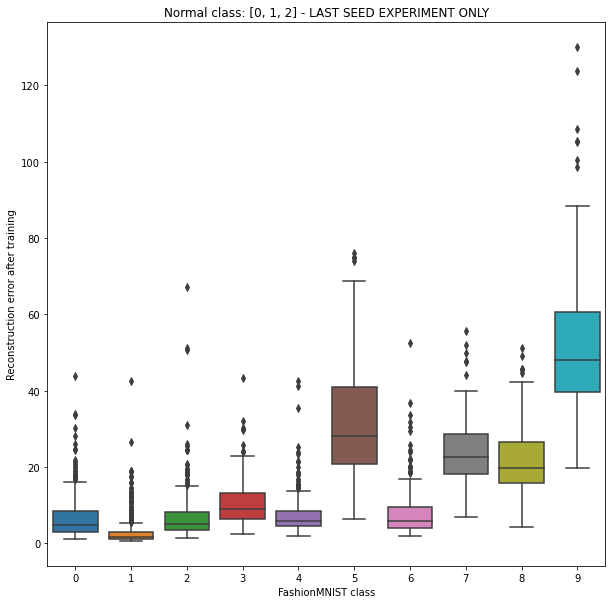

In [6]:
plt.figure(figsize=(10, 10))
boxplot(y=scores_test, x=scores_labels_test)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Reconstruction error after training') # minimum over all centroids for test samples
plt.title('Normal class: {} - LAST SEED EXPERIMENT ONLY'.format(normal_cls))
plt.show()

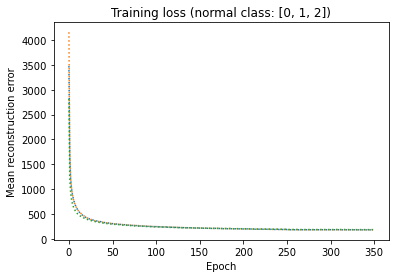

In [7]:
plt.figure()
for seed_idx in range(nbr_seeds):
    plt.plot(range(nbr_epochs), losses[seed_idx,:], linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Mean reconstruction error')
    plt.title('Training loss (normal class: {})'.format(normal_cls))

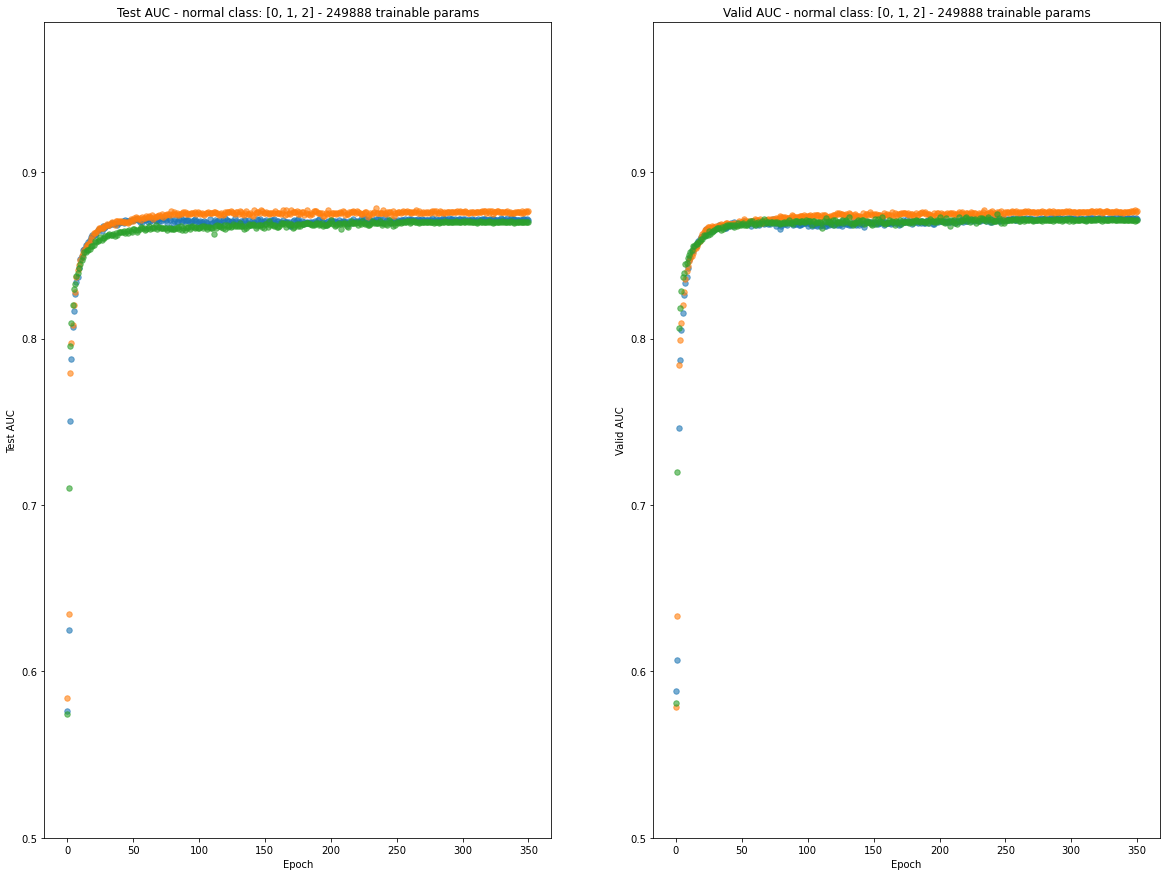

In [8]:
plt.figure(figsize=(20, 15)) 

plt.subplot(1,2,1)
for seed_idx in range(nbr_seeds):
    plt.scatter(range(0, nbr_epochs+1), test_AUCs[seed_idx,:], alpha=0.6, s=30)
    plt.ylim(0.5,0.99)
    plt.xlabel('Epoch')
    plt.ylabel('Test AUC')
    plt.title('Test AUC - normal class: {} - {} trainable params'.format(normal_cls, pytorch_total_params))
    
plt.subplot(1,2,2)
for seed_idx in range(nbr_seeds):
    plt.scatter(range(0, nbr_epochs+1), valid_AUCs[seed_idx,:], alpha=0.6, s=30)
    plt.ylim(0.5,0.99)
    plt.xlabel('Epoch')
    plt.ylabel('Valid AUC')
    plt.title('Valid AUC - normal class: {} - {} trainable params'.format(normal_cls, pytorch_total_params))

In [9]:
test_AUC_at_best_valid = torch.gather(test_AUCs,1,torch.max(valid_AUCs, dim=1)[1].long().unsqueeze(1))
test_AUC_at_best_test = torch.gather(test_AUCs,1,torch.max(test_AUCs, dim=1)[1].long().unsqueeze(1))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUC_at_best_valid),torch.std(test_AUC_at_best_valid)))

MEAN TEST AUC +/- STD: 0.8745653033256531 +/- 0.0033920679707080126


In [10]:
with open('last_results.txt', "a") as file:
    file.write("DeepCAE-{}-Norm{}-BSize{}-LR{}-{}epochs-{}seeds - MEAN TEST AUC (best valid epoch) +/- STD: {} +/- {} | MEAN TEST AUC (best test epoch) +/- STD: {} +/- {}\n".format(dataset, normal_cls, batch_size, learning_rate, nbr_epochs, nbr_seeds, torch.mean(test_AUC_at_best_valid),torch.std(test_AUC_at_best_valid),torch.mean(test_AUC_at_best_test),torch.std(test_AUC_at_best_test)))